In [ ]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from IPython import display
import torch.backends.cudnn as cudnn
import random

def set_seed(seed):
    cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd 'gdrive/MyDrive/Neshan2'
%ls

/content/gdrive/.shortcut-targets-by-id/1kb7msLseHDgbNcoeHcAexfHINwu2zRER/Neshan2
 check_neighbors_average.ipynb
 Classification/
'Copy of check_neighbors_average.ipynb'
'Copy of find_mojood_good_neighors.ipynb'
'Copy of find_mojood_important_good_neighbors.ipynb'
 DATA/
 different_mojood_important_good_neighors.csv
 find_common_days.ipynb
 find_good_segments.ipynb
 find_mojood_good_neighors.ipynb
 find_mojood_important_good_neighbors.ipynb
 find_neighbors.ipynb
 find_shorter_neighbors.ipynb
 get_important_good_segment_information.ipynb
 get_mojood_good_segment_information.ipynb
 GOOD_DATA/
 GOOD_IMPORTANT_DATA/
 good_important_segment_information.csv
 GOOD_MOJOOD_DATA/
 good_mojood_segment_information.csv
 good_segment_information.csv
 igraph.ipynb
 Important_segment.csv
 just_good_neighbors_1000.csv
 just_good_neighbors_1500.csv
 make_mojood_good_days.ipynb
 mlpregressor_scores.txt
 mojood_good_neighors.csv
 mojood_important_good_neighors.csv
 mojood_segment.csv
 NEIGHBOR/
 neighbors

In [ ]:
##finding neighbors and generating neighbors5.csv

In [ ]:
segment_info = pd.read_csv("good_important_segment_information.csv")
print(segment_info.columns)
segment_info = segment_info.values

Index(['Unnamed: 0', 'name', 'segment_id', 'Latitude', 'Longitude'], dtype='object')


In [ ]:
number_of_neighbors = 7
neighbors = []
for i in range(len(segment_info)):
  k_nearest_segments = []
  distances = []
  for j in range(len(segment_info)):
    if segment_info[i][2] != segment_info[j][2]:
      dist = math.sqrt((segment_info[i][3] - segment_info[j][3])**2 + (segment_info[i][4] - segment_info[j][4])**2)
      if len(k_nearest_segments) < number_of_neighbors:
        k_nearest_segments.append(segment_info[j][2])
        distances.append(dist)
      else:
        max_dist = np.max(distances)
        if dist < max_dist:
          max_index = np.argmax(distances)
          k_nearest_segments.pop(max_index)
          distances.pop(max_index)
          k_nearest_segments.append(segment_info[j][2])
          distances.append(dist)
  neighbors.append([segment_info[i][2]] + k_nearest_segments + distances)

In [ ]:
columns = ['segment_id']
for i in range(number_of_neighbors):
  columns.append('n' + str(i + 1))
for i in range(number_of_neighbors):
  columns.append('d' + str(i + 1))
neighbors_df = pd.DataFrame(neighbors, columns=columns)
neighbors_df.to_csv("Shayesteh/neighbors_dist_7.csv")

In [ ]:
##deleting segments with low variances and creating dataset

In [ ]:
number_of_neighbors = 7

In [ ]:
def add_min(date_time, min):
  date = date_time.split()[0]
  time = date_time.split()[1]
  parts = time.split(':')
  hour = int(parts[0])
  minute = int(parts[1])
  second = int(parts[2])
  minute = minute + min
  if minute >= 60:
    hour += (minute // 60)
    minute = minute % 60
  hour = str(hour).zfill(2)
  minute = str(minute).zfill(2)
  second = str(second).zfill(2)

  new_time = hour + ":" + minute + ":" + second
  new_date_time = date + " " + new_time
  return new_date_time

In [ ]:
def convert_time_to_float(date_time):
  date = date_time.split()[0]
  time = date_time.split()[1]
  parts = time.split(':')
  hour = int(parts[0])
  minute = int(parts[1])
  second = int(parts[2])
  total_seconds = hour * 3600 + minute * 60 + second
  radian = total_seconds / (24 * 3600) * math.pi * 2

  return math.sin(radian)

In [ ]:
def get_low_variance_segments(df, threshold):
  variances = df.groupby('Unnamed: 0')['speed'].var()
  low_vars = variances[variances < threshold].index.to_numpy()
  return low_vars

In [ ]:
def filter_neighbors(neighbors, low_vars):
  new_neighgbors = neighbors.loc[~neighbors['segment_id'].isin(low_vars)]
  ns = neighbors.columns[2:]
  for n in ns:
    new_neighgbors = new_neighgbors.loc[~new_neighgbors[n].isin(low_vars)]
  return new_neighgbors

In [ ]:
neighbors_df = pd.read_csv("Shayesteh/neighbors_dist_7.csv")
print(neighbors_df)

       Unnamed: 0    segment_id  ...           d6           d7
0               0  462727807000  ...   438.041094   568.493624
1               1  690922324000  ...   642.446885   865.202866
2               2  690922324001  ...   496.037297   674.896288
3               3  690922324002  ...   466.744041  1173.882447
4               4    4824105000  ...   955.598242   721.781823
...           ...           ...  ...          ...          ...
23093       23093  764361179002  ...   578.760745   540.092585
23094       23094  764361179003  ...  1118.284400   540.092585
23095       23095  306248024000  ...   985.426304   164.842349
23096       23096  632174936000  ...   238.002101   590.407486
23097       23097  632174936001  ...  1757.204883  1639.538045

[23098 rows x 16 columns]


In [ ]:
segment_data = {}
intervals = [0, 5, 10, 15, 20, 24]

In [ ]:
day = '1'
dataset = []

In [ ]:
day_df = pd.read_csv("GOOD_IMPORTANT_DATA/good_important_segment_day" + day + ".csv")
low_var_segs = get_low_variance_segments(day_df, 100)
filtered_day_df = day_df.loc[~day_df['Unnamed: 0'].isin(low_var_segs)]
filtered_neighbors = filter_neighbors(neighbors_df, low_var_segs)

In [ ]:
print(filtered_neighbors.shape)
print(low_var_segs.shape)
print(filtered_day_df.shape)

(1885, 16)
(14554,)
(713311, 3)


In [ ]:
##clustering segments

In [ ]:
def find_index(intervals, date_time):
  time = date_time.split()[1]
  parts = time.split(':')
  hour = int(parts[0])
  for i in range(len(intervals)):
    if hour < intervals[i]:
      index = max(0, i - 1)
      break
  return index

In [ ]:
for i in range(len(filtered_day_df)):
  record = filtered_day_df.iloc[i]
  segment_id = record['Unnamed: 0']
  date_time = record['date_time']
  if segment_id not in segment_data:
    segment_data[segment_id] = [[] for i in range(len(intervals) - 1)]
  index = find_index(intervals, date_time)
  segment_data[segment_id][index].append(record['speed'])

In [ ]:
segment_info = []
for s in segment_data:
  seg = [s]
  for i in range(len(intervals) - 1):
    if len(segment_data[s][i]) == 0:
      seg.extend([-1, -1])
      continue
    seg.append(np.mean(segment_data[s][i]))
    seg.append(np.var(segment_data[s][i]))
  segment_info.append(seg)
segment_info = np.array(segment_info)

In [ ]:
columns = ['segment_id']
for i in range(len(intervals) - 1):
  columns.extend(['mean' + str(i+1), 'var' + str(i+1)])
info_df = pd.DataFrame(segment_info, columns = columns)
info_df.to_csv("Shayesteh/dataset/segment_info_" + str(len(intervals) - 1) + ".csv")

['segment_id', 'mean1', 'var1', 'mean2', 'var2', 'mean3', 'var3', 'mean4', 'var4', 'mean5', 'var5']


In [ ]:
cluster_input = segment_info[:,1:]
kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_input)
labels = kmeans.labels_

<function matplotlib.pyplot.show>

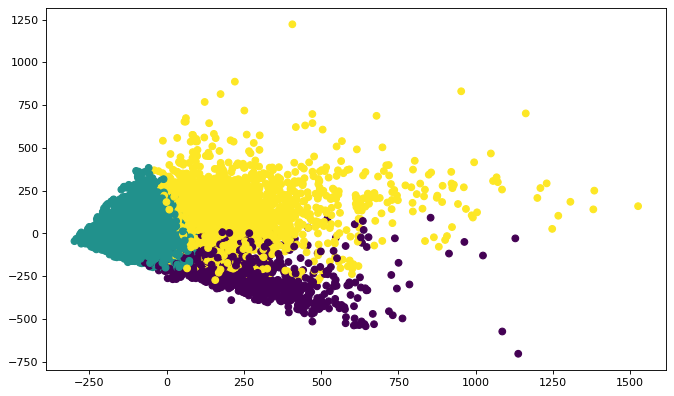

In [ ]:
pca = PCA(n_components=2)
cluster_reduced = pca.fit_transform(cluster_input)

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(cluster_reduced[:,0], cluster_reduced[:,1], c = labels)
plt.show

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1631, 1: 16010, 2: 4508}


In [ ]:
indices0 = np.argwhere(labels == 0)
segments0 = info_df['segment_id'].to_numpy()[indices0]

indices1 = np.argwhere(labels == 1)
segments1 = info_df['segment_id'].to_numpy()[indices1]

indices2 = np.argwhere(labels == 2)
segments2 = info_df['segment_id'].to_numpy()[indices2]

print(len(segments0), len(segments1), len(segments2))

1631 16010 4508


In [ ]:
#creating dataset

In [ ]:
for i in range(len(filter_neighbors)):
  if i % 100 == 0:
    print(i)
  record = filtered_neighbors.iloc[i].to_numpy()
  segment_id = record[1]
  segment_records = filtered_day_df[filtered_day_df['Unnamed: 0'] == segment_id]
  segment_times = segment_records['date_time'].to_numpy()
  intersect_times = segment_times
  if len(segment_times) < 1:
    continue
  neighbors = []
  for id in record[2:2+number_of_neighbors]:
    id_records = filtered_day_df[(filtered_day_df['Unnamed: 0'] == id) & filtered_day_df['date_time'].isin(intersect_times)]
    neighbors.append(id_records)
    intersect_times = id_records['date_time'].to_numpy()
    if len(intersect_times) == 0:
      break
  if len(intersect_times) > 0:
    for time in intersect_times:
      next_time = add_min(time, 15)
      if next_time not in segment_times:
        continue
      sample = [convert_time_to_float(time)]
      sample.append(segment_records[segment_records['date_time'] == time]['speed'].to_numpy()[0])
      for n in range(len(neighbors)):
        sample.append(neighbors[n][neighbors[n]['date_time'] == time]['speed'].to_numpy()[0])
        sample.append(record[number_of_neighbors + n + 2])
      sample.append(segment_records[segment_records['date_time'] == next_time]['speed'].to_numpy()[0])
      dataset.append(sample)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [ ]:
print(len(dataset))

144378


In [ ]:
columns = ['Time', 'case']
for i in range(number_of_neighbors):
  columns.append('PC' + str(i+1))
  columns.append('dist' + str(i+1))
columns.append('label')
dataset_df = pd.DataFrame(dataset, columns = columns)
dataset_df.to_csv("Shayesteh/dataset/dataset_dist_7/dataset_" + day + ".csv")

In [ ]:
#training neural network

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [ ]:
dataset = []
batch_size = 64

In [ ]:
for i in range(1, 20):
  day = str(i)
  day_df = pd.read_csv("Shayesteh/dataset/dataset_dist_7/dataset_" + day + ".csv")
  dataset.extend(day_df.drop(columns=['Unnamed: 0']).to_numpy())
  print(len(dataset))

276850
591742
899990
1160381
1473823
1818871
2267257
2437515
2574649
2739040
2855750
2974029
3127969
3320706
3366130
3431324
3507057
3564787
3709165


In [ ]:
dataset = np.asarray(dataset).astype('float32')
np.random.shuffle(dataset)

train_size = int(0.7*len(dataset))
train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_in_set = train_set[:, :-1]
train_out_set = train_set[:, -1:]

test_in_set = test_set[:, :-1]
test_out_set = test_set[:, -1:]

In [ ]:
class TrafficDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __getitem__(self, index):
      return torch.from_numpy(self.data[index]), torch.from_numpy(self.labels[index])
        
    def __len__(self):
        return len(self.data)  

In [ ]:
train_set = TrafficDataset(train_in_set, train_out_set)
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_set = TrafficDataset(test_in_set, test_out_set)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
(batch_data, batch_label) = next (iter (train_loader))
model = NeuralNetwork().to(device)
output = model(batch_data.to(device)).cpu()
print(output.shape)

torch.Size([64, 1])


In [ ]:
model = NeuralNetwork().to(device)

criterion = nn.MSELoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters() , lr=1e-3)

In [ ]:
train_log = []
test_log = []
set_seed(111)
current_epoch = 1

In [ ]:
#load model
checkpoint = torch.load("Shayesteh/models/current_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
current_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
#load losses
with open("Shayesteh/models/train_loss.txt", "r") as train_file:
  train_losses = [float(l) for l in train_file.readlines()]
  train_log.extend(train_losses)

with open("Shayesteh/models/test_loss.txt", "r") as test_file:
  test_losses = [float(l) for l in test_file.readlines()]
  test_log.extend(test_losses)

train_log = train_log[:current_epoch]
test_log = test_log[:current_epoch]

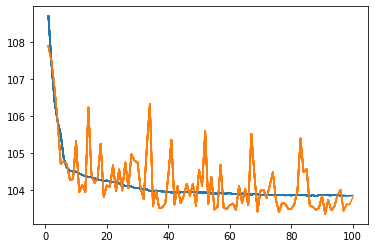

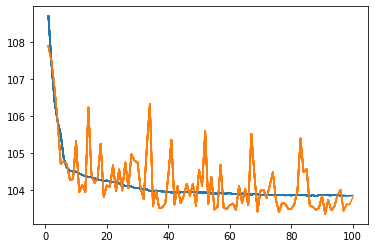

In [ ]:
epoch_num = 100

for epoch in range(current_epoch + 1, epoch_num+1):
    
    running_loss = 0    
    train_loss = []
    model.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()                
        optimizer.step()        
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    model.eval()
    with torch.no_grad():                
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):         
            inputs, labels = inputs.to(device), labels.to(device)        
            outputs = model(inputs)                       
            loss = criterion(outputs, labels)            
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))    

    #save losses
    with open("Shayesteh/models/train_loss.txt", "a") as train_file:
      train_file.write(str(train_log[-1]) + "\n")

    with open("Shayesteh/models/test_loss.txt", "a") as test_file:
      test_file.write(str(test_log[-1]) + "\n")
    
    #plot losses
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

    #save model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "Shayesteh/models/current_model.pt")

In [ ]:
#evaluation

In [ ]:
y_true = []
y_pred = []
prev_speed = []
neighbor_mean = []

with torch.no_grad():
    model.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):
        inputs, labels = inputs.to(device), labels.to(device)  
        outputs = model(inputs)
        prev = [i[1] for i in inputs.tolist()]
        prev_speed.extend(prev)
        mean = [np.mean(i[2:]) for i in inputs.tolist()]
        neighbor_mean.extend(mean)
        true_list = [i[0] for i in labels.tolist()]
        y_true.extend(true_list)
        pred_list = [i[0] for i in outputs.tolist()]
        y_pred.extend(pred_list)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
prev_speed = np.array(prev_speed)
neighbor_mean = np.array(neighbor_mean)

Test:   0%|          | 0/20855 [00:00<?, ?it/s]

In [ ]:
print(len(neighbor_mean))

1334663


In [ ]:
mse = mean_squared_error(y_true, y_pred)
print("test data mse: ", mse)

prev_mse = mean_squared_error(y_true, prev_speed)
print("test data mse if the NN used previous speed as output: ", prev_mse)

mean_mse = mean_squared_error(y_true, neighbor_mean)
print("test data mse if the NN used mean of neighbor segments as output: ", mean_mse)

test data mse:  103.9716595204619
test data mse if the NN used previous speed as output:  125.59160776915222
test data mse if the NN used mean of neighbor segments as output:  172.75895149562095


In [ ]:
mse = mean_squared_error(y_true, y_pred)
print("test data mse: ", mse)

mae = mean_absolute_error(y_true, y_pred)
print("test data mae: ", mae)

r2 = r2_score(y_true, y_pred)
print("test data r2 score: ", r2)

test data mse:  103.9716595204619
test data mae:  7.110329712688381
test data r2 score:  0.7470618923939973


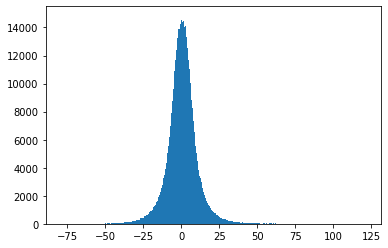

In [ ]:
plt.hist(y_true - y_pred, color='C0', bins = 1000)
plt.show()

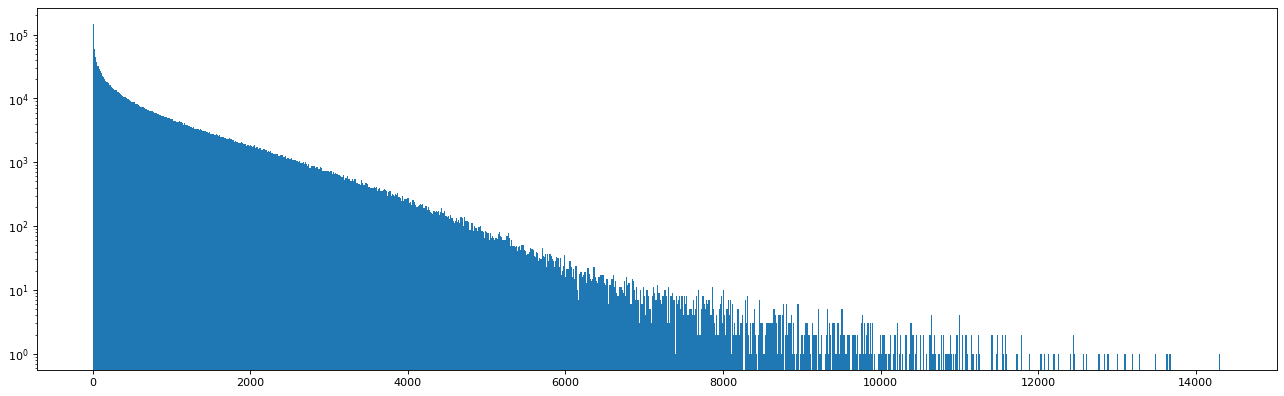

In [ ]:
square = (y_true - y_pred)**2
# square = square[square < 2000]
plt.figure(figsize=(20, 6), dpi=80)
plt.hist((y_true - y_pred)**2, color='C0', bins = 1000)
plt.yscale('log')
plt.show()

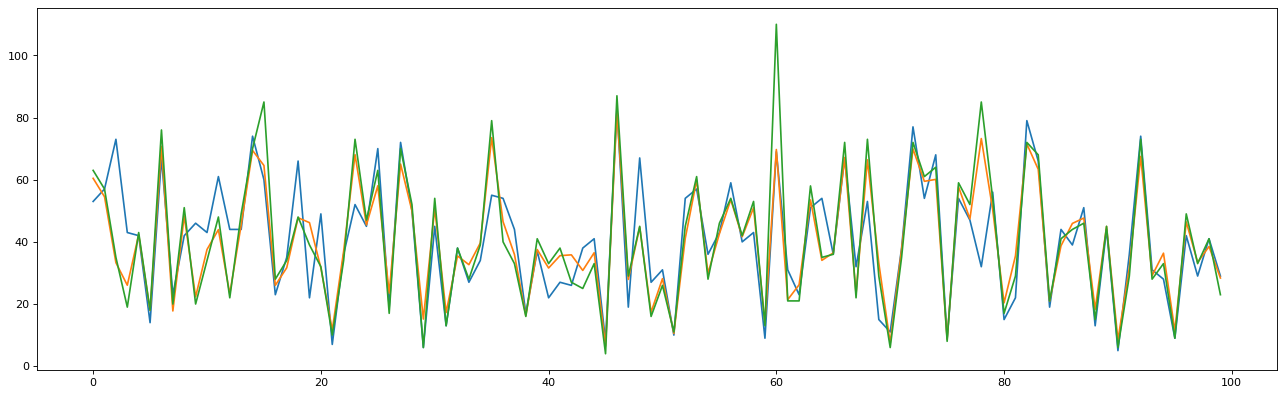

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(y_true[:100], color='C0')
plt.plot(y_pred[:100], color='C1')
plt.plot(prev_speed[:100], color='C2')
plt.show()

In [ ]:
#XGBoost

In [ ]:
print(train_out_set[:, 0].shape)

(2596415,)


In [ ]:
xg_reg = xgb.XGBRegressor(n_estimators=100, nthread=4, eta=0.01, gamma=1, max_depth=7, min_child_weight=2, subsample=0.9, colsample_bytree=1, alpha=0.005, seed=27)
xg_reg.fit(train_in_set, train_out_set)
y_pred = xg_reg.predict(test_in_set)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[07:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
mse = mean_squared_error(test_out_set, y_pred)
print("test data mse: ", mse)

mae = mean_absolute_error(test_out_set, y_pred)
print("test data mae: ", mae)

r2 = r2_score(test_out_set, y_pred)
print("test data r2 score: ", r2)

test data mse:  95.574356
test data mae:  6.8194246
test data r2 score:  0.7703338980555423


In [ ]:
mse = mean_squared_error(test_out_set, y_pred)
print("test data mse: ", mse)

prev_mse = mean_squared_error(test_out_set, test_in_set[:,1])
print("test data mse if the NN used previous speed as output: ", prev_mse)

test data mse:  95.574356
test data mse if the NN used previous speed as output:  122.090546


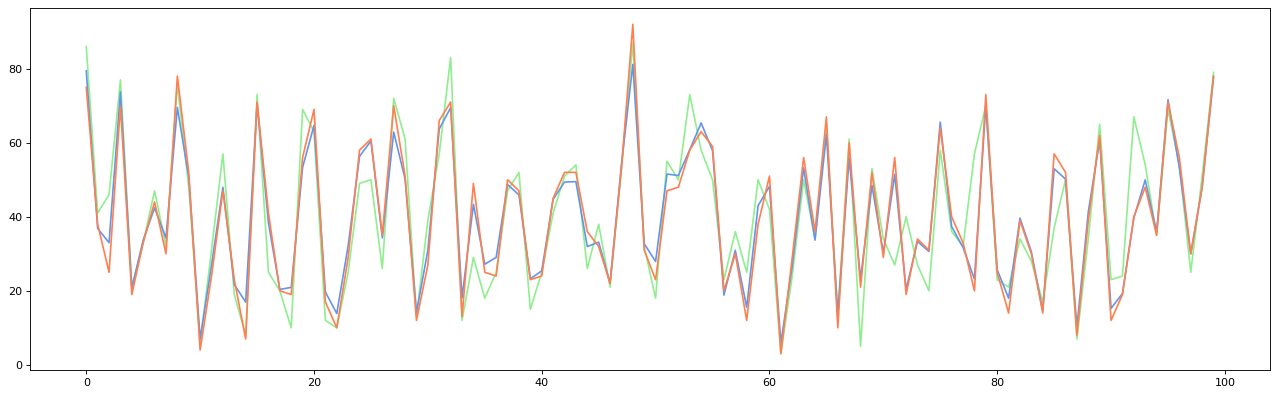

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(test_out_set[:100], color='lightgreen')
plt.plot(y_pred[:100], color='cornflowerblue')
plt.plot(test_in_set[:100, 1], color='coral')
plt.show()

In [ ]:
#MLP

In [ ]:
regr = MLPRegressor(hidden_layer_sizes = (100, 50, 20, 15, 10, 7, 5, 3), batch_size=64, activation='relu', solver='adam', 
                    learning_rate='constant', verbose = True, max_iter = 100)
regr.fit(train_in_set, train_out_set)
y_pred = regr.predict(test_in_set)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 414.15671938
Iteration 2, loss = 53.13877984
Iteration 3, loss = 52.47600213
Iteration 4, loss = 51.91842773
Iteration 5, loss = 51.41284914
Iteration 6, loss = 51.11629768
Iteration 7, loss = 50.99807937
Iteration 8, loss = 50.87861375
Iteration 9, loss = 50.79469591
Iteration 10, loss = 50.74612220
Iteration 11, loss = 50.67996305
Iteration 12, loss = 50.63985276
Iteration 13, loss = 50.56283670
Iteration 14, loss = 50.50832966
Iteration 15, loss = 50.45560930
Iteration 16, loss = 50.41313810
Iteration 17, loss = 50.37651815
Iteration 18, loss = 50.36987413
Iteration 19, loss = 50.34759868
Iteration 20, loss = 50.32259885
Iteration 21, loss = 50.27313949
Iteration 22, loss = 50.27063840
Iteration 23, loss = 50.25189272
Iteration 24, loss = 50.23403501
Iteration 25, loss = 50.22291510
Iteration 26, loss = 50.21189463
Iteration 27, loss = 50.20110257
Iteration 28, loss = 50.17194146
Iteration 29, loss = 50.14138895
Iteration 30, loss = 50.12374445
Iteration 31, loss

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
mse = mean_squared_error(test_out_set, y_pred)
print("test data mse: ", mse)

mae = mean_absolute_error(test_out_set, y_pred)
print("test data mae: ", mae)

r2 = r2_score(test_out_set, y_pred)
print("test data r2 score: ", r2)

test data mse:  98.94315
test data mae:  6.9306846
test data r2 score:  0.761945552492612


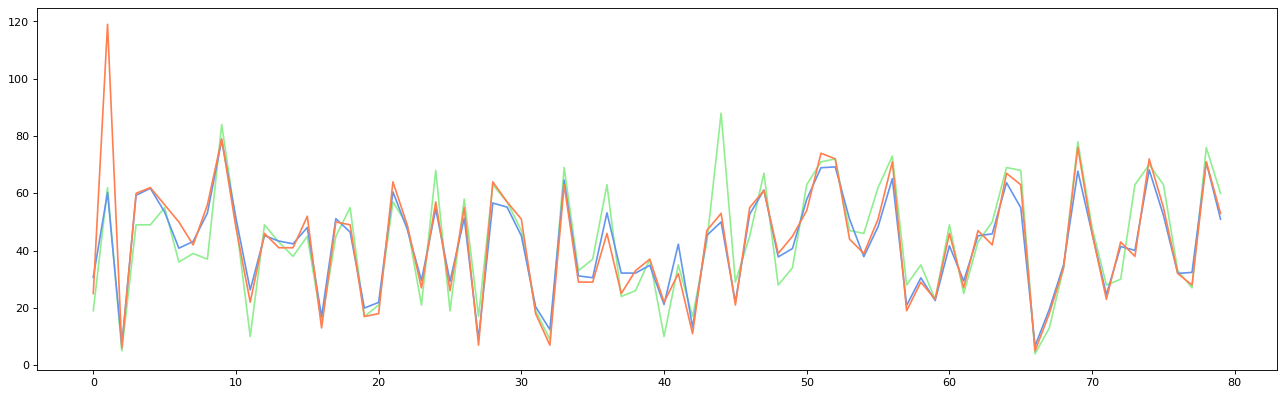

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(test_out_set[:200], color='lightgreen')
plt.plot(y_pred[:200], color='cornflowerblue')
plt.plot(test_in_set[:200, 1], color='coral')
plt.show()